# Interactive visualization

In [1]:
import os
import pandas as pd
import numpy as np
import json
import folium
from IPython.display import display, HTML
from ipywidgets import widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import branca.colormap as cm
from matplotlib import colors

**NB:**

- We commented every display of map to avoid displaying a big white box on github. If you want to run the notebook and see the maps please uncomment them.

# European unemployment rates
The dataset for european unemployment rates can be found on [eurostat](http://ec.europa.eu/eurostat/data/database) by using the search bar and looking for the term "Unemployment rate". We have chosen the dataset with code `tepsr_wc170`, selecting the largest age group (15-75), because it also contains the unemployment rate of Switzerland. We download it using the .xls format because it is much cleaner than the .tsv version. We added an external preprocessing step with Excel where we simply deleted the textual descriptions in the file and unnecessary columns. This will lead to a cleaner code for loading the data. There is also subtelty that arises when plotting the choropleth map. If instead of the xls file we had taken the tsv format, we would have received data with two-letters country indicators (such as FR for France). However, the codes used by eurostat do not match the codes used in the topojson file. Therefore, taking the xls format has the additional advantage to enumerate countries by their full names which are a better match to our topojson file.

In [2]:
europe_unemployment_data_2016 = pd.read_csv('data/europe_unemployment.csv', names=['Country', 'Rate'], header=0)

# Remove entries with no data
europe_unemployment_data_2016 = europe_unemployment_data_2016[europe_unemployment_data_2016.Rate != ':']

# Convert to numeric values
europe_unemployment_data_2016 = europe_unemployment_data_2016.apply(pd.to_numeric, errors='ignore')

Before creating the choropleth map, let us look at the distribution of unemployment rates across european countries:

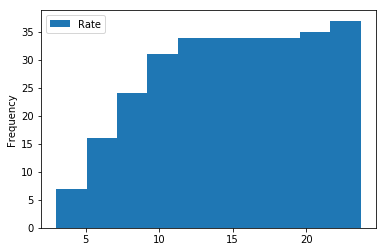

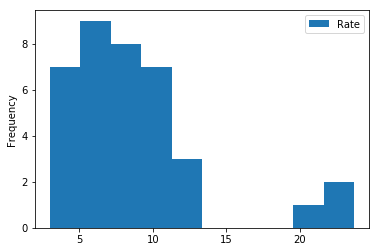

In [3]:
europe_unemployment_data_2016.plot.hist(cumulative=True)
europe_unemployment_data_2016.plot.hist()
plt.show()

Because the threshold by default of the choropleth maps is linear (even though the documentation says it is not), we decided the tune it according to the above histograms to better visualise the difference between european countries. For this, we will use the following quantiles:

In [4]:
print(europe_unemployment_data_2016.Rate.quantile([0, .1, .25, .5, .9, 1.]))

0.00     3.00
0.10     4.70
0.25     6.00
0.50     7.90
0.90    13.04
1.00    23.70
Name: Rate, dtype: float64


We then load the TopoJson file. Note that Folium will still show geometries contained in the TopoJson which do not have any data associated to them. This can be very misleading as it may suggest that the countries for which we do not have any data have actually a low unemployment rate. This is we perform a quick filtering operation on the TopoJson file to remove any country that is not present in our unemployment dataset.

In [5]:
europe_json = json.load(open("topojson/europe.topojson.json"))

europe_json['objects']['europe']['geometries'] = \
                        [
                            x
                            for x in europe_json['objects']['europe']['geometries'] 
                            if (x['properties']['NAME'] in europe_unemployment_data_2016['Country'].values)
                        ]

We can finally display the map. **See it** [here](https://lkieliger.github.io/adagroup/Europe_Unemployment.html)

In [6]:
m = folium.Map([47.870833, 9.085721], tiles='Mapbox Bright', zoom_start=4)
m.choropleth(europe_json, 
             data=europe_unemployment_data_2016, 
             columns=['Country', 'Rate'], 
             key_on='feature.properties.NAME', # Joining on names
             fill_color='YlOrRd',
             topojson='objects.europe',
             line_color='gray',
             legend_name='Unemployment rate in %',
             threshold_scale=list(europe_unemployment_data_2016.Rate.quantile([0, .10, .25, .5, .9, 1.]).values)
             )
m.save('Europe_Unemployment.html')

#display(m)

We see that the Swiss unemployment rate is quite low in comparison to most of the european countries.

# 2 Swiss unemployment data
## 2.a Jobless people rate
We can apply the same methodology to display the unemployment rates in Switzerland, down at the canton level. We start by loading the dataset:

In [7]:
swiss_unemployment_data = pd.read_csv('data/swiss_unemployment_total.csv')
swiss_unemployment_rates = swiss_unemployment_data.copy()[['Canton','Taux de chômage (1 cav)','Taux de chômage des jeunes (1 pdv)']]
swiss_unemployment_rates.head()

,Canton,Taux de chômage (1 cav),Taux de chômage des jeunes (1 pdv)
0,Zurich,3.7,4.1
1,Berne,2.7,2.9
2,Vaud,4.7,4.4
3,Argovie,3.2,3.2
4,Genève,5.5,5.4


To join on the TopoJson region names we convert the names of the cantons into their two-letters code.

In [8]:
cantons_dict = {'Zurich': 'ZH', 'Berne': 'BE','Lucerne':'LU','Uri':'UR','Schwyz':'SZ',
    'Obwald':'OW','Nidwald':'NW','Glaris':'GL','Zoug':'ZG','Fribourg':'FR',
    'Soleure':'SO','Bâle-Ville':'BS','Bâle-Campagne':'BL','Schaffhouse':'SH',
    'Appenzell Rhodes-Extérieures':'AR','Appenzell Rhodes-Intérieures':'AI',
    'St-Gall':'SG','Grisons':'GR','Argovie':'AG','Thurgovie':'TG','Tessin':'TI',
    'Vaud':'VD','Valais':'VS','Neuchâtel':'NE','Genève':'GE','Jura':'JU'}

swiss_unemployment_rates.Canton.replace(cantons_dict, inplace=True)

Finally, we can display the choropleth map. **See it** [here](https://lkieliger.github.io/adagroup/Swiss_unemployment.html)

In [9]:
swiss_json = json.load(open("topojson/ch-cantons.topojson.json"))

map_ = folium.Map([46.819393, 8.333115], tiles='CartoDBpositron', zoom_start=8)
map_.choropleth(swiss_json, 
             data=swiss_unemployment_rates, 
             columns=['Canton', 'Taux de chômage (1 cav)'], 
             key_on='feature.id', 
             fill_color='YlOrRd',
             topojson='objects.cantons',
             line_color='gray',
                legend_name='Unemployment rate in %'
             )

map_.save('Swiss_unemployment.html')

#display(map_)

## Trends
We observe that the regions with the highest unemployment rates tend to be the ones with the largest cities such as Zürich, Lausanne and Geneva. In addition, regions close to the borders and well connected by infrastructures such as Genève, Vaud, Neuchâtel, Ticino and Jura, tend to present higher unemployment rates.

## 2.b Alternative definition of unemployment: jobseekers rate

Now we also consider in our rates the number of people that currently have a job but are also registered in a placement office. Because we only have totals available for this variable instead of rates, we need to compute it ourselves. To this end, we will load a different dataset. It contains the total number of job seekers without a job as well as job seekers with a job. We will use the former to find back the number of active people per canton and finally, compute the rates of job seekers with a current job.

In [10]:
swiss_unemployment_numbers_data = pd.read_csv('data/swiss_unemployed_and_job_seekers.csv')
swiss_unemployment_numbers = swiss_unemployment_numbers_data.copy()
swiss_unemployment_numbers.head(3)

,Canton,Mois,Janvier 2016,Janvier 2016.1,Février 2016,Février 2016.1,Mars 2016,Mars 2016.1,Avril 2016,Avril 2016.1,...,Août 2016,Août 2016.1,Septembre 2016,Septembre 2016.1,Octobre 2016,Octobre 2016.1,Novembre 2016,Novembre 2016.1,Décembre 2016,Décembre 2016.1
0,,Mesures,Chômeurs inscrits,Demandeurs d'emploi,Chômeurs inscrits,Demandeurs d'emploi,Chômeurs inscrits,Demandeurs d'emploi,Chômeurs inscrits,Demandeurs d'emploi,...,Chômeurs inscrits,Demandeurs d'emploi,Chômeurs inscrits,Demandeurs d'emploi,Chômeurs inscrits,Demandeurs d'emploi,Chômeurs inscrits,Demandeurs d'emploi,Chômeurs inscrits,Demandeurs d'emploi
1,Zurich,NaN,31'331,37'642,31'502,37'956,30'820,37'352,29'876,36'389,...,29'100,35'790,29'462,36'233,29'768,36'691,30'651,37'720,31'570,38'591
2,Berne,NaN,16'502,21'053,16'264,20'982,15'942,20'902,15'370,20'093,...,14'487,18'986,14'516,19'218,14'888,19'836,15'753,20'961,16'636,21'637




We extract the two variables of interest: "Demandeurs d'emploi" and "Chômeurs inscrits"


In [11]:
chomeurs_mask = swiss_unemployment_numbers.columns.str.endswith("2016")
demandeurs_mask = swiss_unemployment_numbers.columns.str.endswith("2016.1")

swiss_unemployment_numbers_chomeurs = pd.concat([
    swiss_unemployment_numbers['Canton'],
    swiss_unemployment_numbers.iloc[:, chomeurs_mask]
], axis=1)[1:]

swiss_unemployment_numbers_demandeurs = pd.concat([
    swiss_unemployment_numbers['Canton'],
    swiss_unemployment_numbers.iloc[:, demandeurs_mask]
], axis=1)[1:]

We take the average over the year for each canton:

In [12]:
# Clean values and convert to numeric type
swiss_unemployment_numbers_chomeurs.replace("'", '', inplace=True, regex=True)
swiss_unemployment_numbers_demandeurs.replace("'", '', inplace=True, regex=True)
swiss_unemployment_numbers_chomeurs = swiss_unemployment_numbers_chomeurs.apply(pd.to_numeric, errors='ignore')
swiss_unemployment_numbers_demandeurs = swiss_unemployment_numbers_demandeurs.apply(pd.to_numeric, errors='ignore')
      
# Compute average
swiss_unemployment_numbers_chomeurs['AVG'] = swiss_unemployment_numbers_chomeurs.mean(axis=1)
swiss_unemployment_numbers_demandeurs['AVG'] = swiss_unemployment_numbers_demandeurs.mean(axis=1)

# Keep only cantons and average
swiss_unemployment_numbers_chomeurs = swiss_unemployment_numbers_chomeurs[['Canton', 'AVG']]
swiss_unemployment_numbers_demandeurs = swiss_unemployment_numbers_demandeurs[['Canton', 'AVG']]

# Convert cantons to two-letters code
swiss_unemployment_numbers_chomeurs.Canton.replace(cantons_dict, inplace=True)
swiss_unemployment_numbers_demandeurs.Canton.replace(cantons_dict, inplace=True)

# Remove totals
swiss_unemployment_numbers_chomeurs = swiss_unemployment_numbers_chomeurs[swiss_unemployment_numbers_chomeurs['Canton'] != 'Total']
swiss_unemployment_numbers_demandeurs = swiss_unemployment_numbers_demandeurs[swiss_unemployment_numbers_demandeurs['Canton'] != 'Total']

print(swiss_unemployment_numbers_chomeurs.head(3))
print(swiss_unemployment_numbers_demandeurs.head(3))

  Canton           AVG
1     ZH  30083.916667
2     BE  15283.166667
3     LU   4601.750000
  Canton           AVG
1     ZH  36785.916667
2     BE  20084.250000
3     LU   7466.583333




We can now compute the active population by canton using the dataframe from the previous question. We have:
$$ \textrm{unemployment rate}= \frac{\textrm{unemployed people}}{\textrm{active population}} \Leftrightarrow \textrm{active population}= \frac{\textrm{unemployed people}}{\textrm{unemployment rate}}$$


In [13]:
# Sort by canton to align the data
swiss_unemployment_rates_sorted = swiss_unemployment_rates.sort_values('Canton').reset_index(drop=True)
swiss_unemployment_numbers_chomeurs_sorted = swiss_unemployment_numbers_chomeurs.sort_values('Canton').reset_index(drop=True)

# Convert rates to numeric
swiss_unemployment_rates_sorted = swiss_unemployment_rates_sorted.apply(pd.to_numeric, errors='ignore')

swiss_active_population = pd.DataFrame(100.0 * swiss_unemployment_numbers_chomeurs_sorted['AVG'] / swiss_unemployment_rates_sorted['Taux de chômage (1 cav)'], columns=['Total'])
print(swiss_active_population.head())

           Total
0  358869.791667
1    8954.545455
2   30990.740741
3  566043.209877
4  148161.111111




We can finally obtain the rates of job seeker per canton:


In [14]:
# Align the job seeker data
swiss_unemployment_numbers_demandeurs_sorted = swiss_unemployment_numbers_demandeurs.sort_values('Canton').reset_index(drop=True)
swiss_unemployment_numbers_demandeurs_sorted['Taux'] = 100.0 * swiss_unemployment_numbers_demandeurs_sorted['AVG'] / swiss_active_population['Total']
print(swiss_unemployment_numbers_demandeurs_sorted.head())

  Canton           AVG      Taux
0     AG  15975.750000  4.451684
1     AI    141.750000  1.582995
2     AR    952.416667  3.073230
3     BE  20084.250000  3.548183
4     BL   5859.333333  3.954704


With this definition the rates are typically higher. This was to be expected since by definition, unemployed people are a subset of job seekers. Although the distribution changed a bit, the main trend is still present. **See the map** [here](https://lkieliger.github.io/adagroup/Swiss_unemployment_alternative.html).


In [15]:
map_ = folium.Map([46.819393, 8.333115], tiles='CartoDBpositron', zoom_start=8)
map_.choropleth(swiss_json, 
             data=swiss_unemployment_numbers_demandeurs_sorted, 
             columns=['Canton', 'Taux'], 
             key_on='feature.id', 
             fill_color='YlOrRd',
             topojson='objects.cantons',
             line_color='gray',
                legend_name='Job seekers rate in %'
             )

map_.save('Swiss_unemployment_alternative.html')

#display(map_)

# 3 Swiss unemployment, split

## 3.a Split by nationality
We load a new dataset downloaded from amstat. This time, the datasets distinguishes the unemployment rates of Swiss natives and foreigners.

In [16]:
swiss_unemployment_nationality_data = pd.read_csv('data/swiss_unemployment_nationality_split.csv')
swiss_unemployment_nationality_rates = swiss_unemployment_nationality_data.copy()[['Canton','Taux de chômage (1 cav)','Nationalité']]

# Replace the cantons names by their two-letters code
swiss_unemployment_nationality_rates.Canton.replace(cantons_dict, inplace=True)

In [17]:
# Extract the relevant data
swiss_unemployment_foreign_rates = swiss_unemployment_nationality_rates[swiss_unemployment_nationality_rates['Nationalité'] =='Etrangers']
swiss_unemployment_swiss_rates = swiss_unemployment_nationality_rates[swiss_unemployment_nationality_rates['Nationalité'] =='Suisses']

This time we plot two choropleth layers and add a LayerControl object. While not perfect, this allows switching between the visualisations of unemployment rates for Swiss natives and unemployment rates for foreigners. For a fair comparison, the thresholds are set for both map using the quantiles computed using the population for which the rates are the highest. **See the map** [here](https://lkieliger.github.io/adagroup/Swiss_unemployment_split.html).

In [18]:
map_ = folium.Map([46.819393, 8.333115], tiles='CartoDBpositron', zoom_start=8)
map_.choropleth(swiss_json, 
             data=swiss_unemployment_rates, 
             columns=['Canton', 'Taux de chômage (1 cav)'], 
             key_on='feature.id', 
             fill_color='YlOrRd',
             topojson='objects.cantons',
             name="Swiss natives unemployment rates",
             legend_name="Swiss natives unemployment rates in %",
             line_color='gray',
                threshold_scale=list(swiss_unemployment_foreign_rates['Taux de chômage (1 cav)'].quantile([0,.25, .5, .75, 0.9, 1.]))
             )
map_.choropleth(swiss_json, 
             data=swiss_unemployment_foreign_rates, 
             columns=['Canton', 'Taux de chômage (1 cav)'], 
             key_on='feature.id', 
             fill_color='YlGn',
             topojson='objects.cantons',
             name="Foreigners unemployment rates",
             legend_name="Foreigners unemployment rates in %",
                line_color='gray',
             threshold_scale=list(swiss_unemployment_foreign_rates['Taux de chômage (1 cav)'].quantile([0,.25, .5, .75, 0.9, 1.]))
             )
folium.LayerControl(collapsed=False).add_to(map_)

map_.save('Swiss_unemployment_split.html')

#display(map_)

We can better see the difference between the two by plotting the difference between the rates. Note that those difference are in percentage points. **See the map** [here](https://lkieliger.github.io/adagroup/Swiss_unemployment_difference.html).

In [19]:
map_ = folium.Map([46.819393, 8.333115], tiles='CartoDBpositron', zoom_start=8)

# Extract the rates of foreigners
unemployment_difference_foreign_part = swiss_unemployment_foreign_rates[['Canton', 'Taux de chômage (1 cav)']]
unemployment_difference_foreign_part = unemployment_difference_foreign_part.sort_values('Canton').reset_index(drop=True)

# Extract the rates of Swiss natives
unemployment_difference_swiss_part = swiss_unemployment_swiss_rates[['Canton', 'Taux de chômage (1 cav)']]
unemployment_difference_swiss_part = unemployment_difference_swiss_part.sort_values('Canton').reset_index(drop=True)

# Construct a new dataframe with the names of the cantons and the difference between the rates
unemployment_difference = pd.concat([
    unemployment_difference_swiss_part.Canton,
    unemployment_difference_foreign_part['Taux de chômage (1 cav)'] - unemployment_difference_swiss_part['Taux de chômage (1 cav)']
], axis=1)

map_.choropleth(swiss_json, 
             data=unemployment_difference, 
             columns=['Canton', 'Taux de chômage (1 cav)'], 
             key_on='feature.id', 
             fill_color='YlGn',
             topojson='objects.cantons',
             legend_name="Difference in unemployment rates (points)",
                line_color='gray'
             )

map_.save('Swiss_unemployment_difference.html')

# display(map_)

We see that unemployment rates among Swiss natives and unemployment rates among foreigners are proportionnaly equivalent in cantons with big cities. This might be because in more rural areas there is a tendency to prefer local workers over foreigners.

## 3.b Split by nationality and age

In [20]:
def to_numeric(x):
    return(x.str.replace('\'', '')).astype('int64')

def rename_age(x):
    if(x == '1'):
        return ' 15 - 24 years'
    elif(x == '2'):
        return ' 25 - 49 years'
    else:
        return ' 50+ years'
    
def rename_nationality(x):
    if(x == 'Etrangers'):
        return 'Foreigners'
    else:
        return 'Swiss'

We load a new dataset containing the additional categories we are interested in. Unfortunately, it is not possible to directly obtain from amstat the rates for those categories. One solution would be to find on the [OFS](https://www.bfs.admin.ch/bfs/fr/home.html) website the number of active people in each of those categories and use it to compute the rates. However, we decided that this went beyond the requirements of this homework as this involved data outsite from amstat and decided to settle instead with the absolute number of those categories.

In [21]:
swiss_unemployment_nationality_age_data = pd.read_csv('data/swiss_unemployment_nationality_age_split.csv')
swiss_unemployment_nationality_age_rates = swiss_unemployment_nationality_age_data.copy()

# Remove unnecessary column, clean and convert values
swiss_unemployment_nationality_age_rates = swiss_unemployment_nationality_age_rates.drop(['Unnamed: 3','Mois'], 1)
swiss_unemployment_nationality_age_rates.loc[:,"Janvier 2016":"Décembre 2016"] = swiss_unemployment_nationality_age_rates.loc[:,"Janvier 2016":"Décembre 2016"].apply(lambda x: to_numeric(x), axis=1)
swiss_unemployment_nationality_age_rates["Mean"] = (swiss_unemployment_nationality_age_rates.loc[:,"Janvier 2016":"Décembre 2016"].sum(axis=1)/12).astype('int64')

swiss_unemployment_nationality_age_rates = swiss_unemployment_nationality_age_rates[['Canton','Nationalité','Classes d\'âge 15-24, 25-49, 50 ans et plus','Mean']]

# Remove unnecessary rows
swiss_unemployment_nationality_age_rates = swiss_unemployment_nationality_age_rates[swiss_unemployment_nationality_age_rates['Canton'] != 'Total']
swiss_unemployment_nationality_age_rates = swiss_unemployment_nationality_age_rates[swiss_unemployment_nationality_age_rates['Nationalité'] != 'Total']
swiss_unemployment_nationality_age_rates = swiss_unemployment_nationality_age_rates[swiss_unemployment_nationality_age_rates['Classes d\'âge 15-24, 25-49, 50 ans et plus'] != 'Total']

# Rename columns
swiss_unemployment_nationality_age_rates['Classes d\'âge 15-24, 25-49, 50 ans et plus'] = swiss_unemployment_nationality_age_rates['Classes d\'âge 15-24, 25-49, 50 ans et plus'].apply(lambda x: rename_age(x))
swiss_unemployment_nationality_age_rates['Nationalité'] = swiss_unemployment_nationality_age_rates['Nationalité'].apply(lambda x: rename_nationality(x))

# Assemble 
swiss_unemployment_nationality_age_rates['Nationality and age'] = swiss_unemployment_nationality_age_rates['Nationalité'] + swiss_unemployment_nationality_age_rates['Classes d\'âge 15-24, 25-49, 50 ans et plus'] 
swiss_unemployment_nationality_age_rates = swiss_unemployment_nationality_age_rates.pivot(index='Canton', columns= 'Nationality and age', values='Mean')

display(swiss_unemployment_nationality_age_rates.head(3))

Nationality and age,Foreigners 15 - 24 years,Foreigners 25 - 49 years,Foreigners 50+ years,Swiss 15 - 24 years,Swiss 25 - 49 years,Swiss 50+ years
Canton,,,,,,
Appenzell Rhodes-Extérieures,19,128,57,55,155,141
Appenzell Rhodes-Intérieures,5,24,14,10,24,17
Argovie,605,3764,1109,921,3094,1988


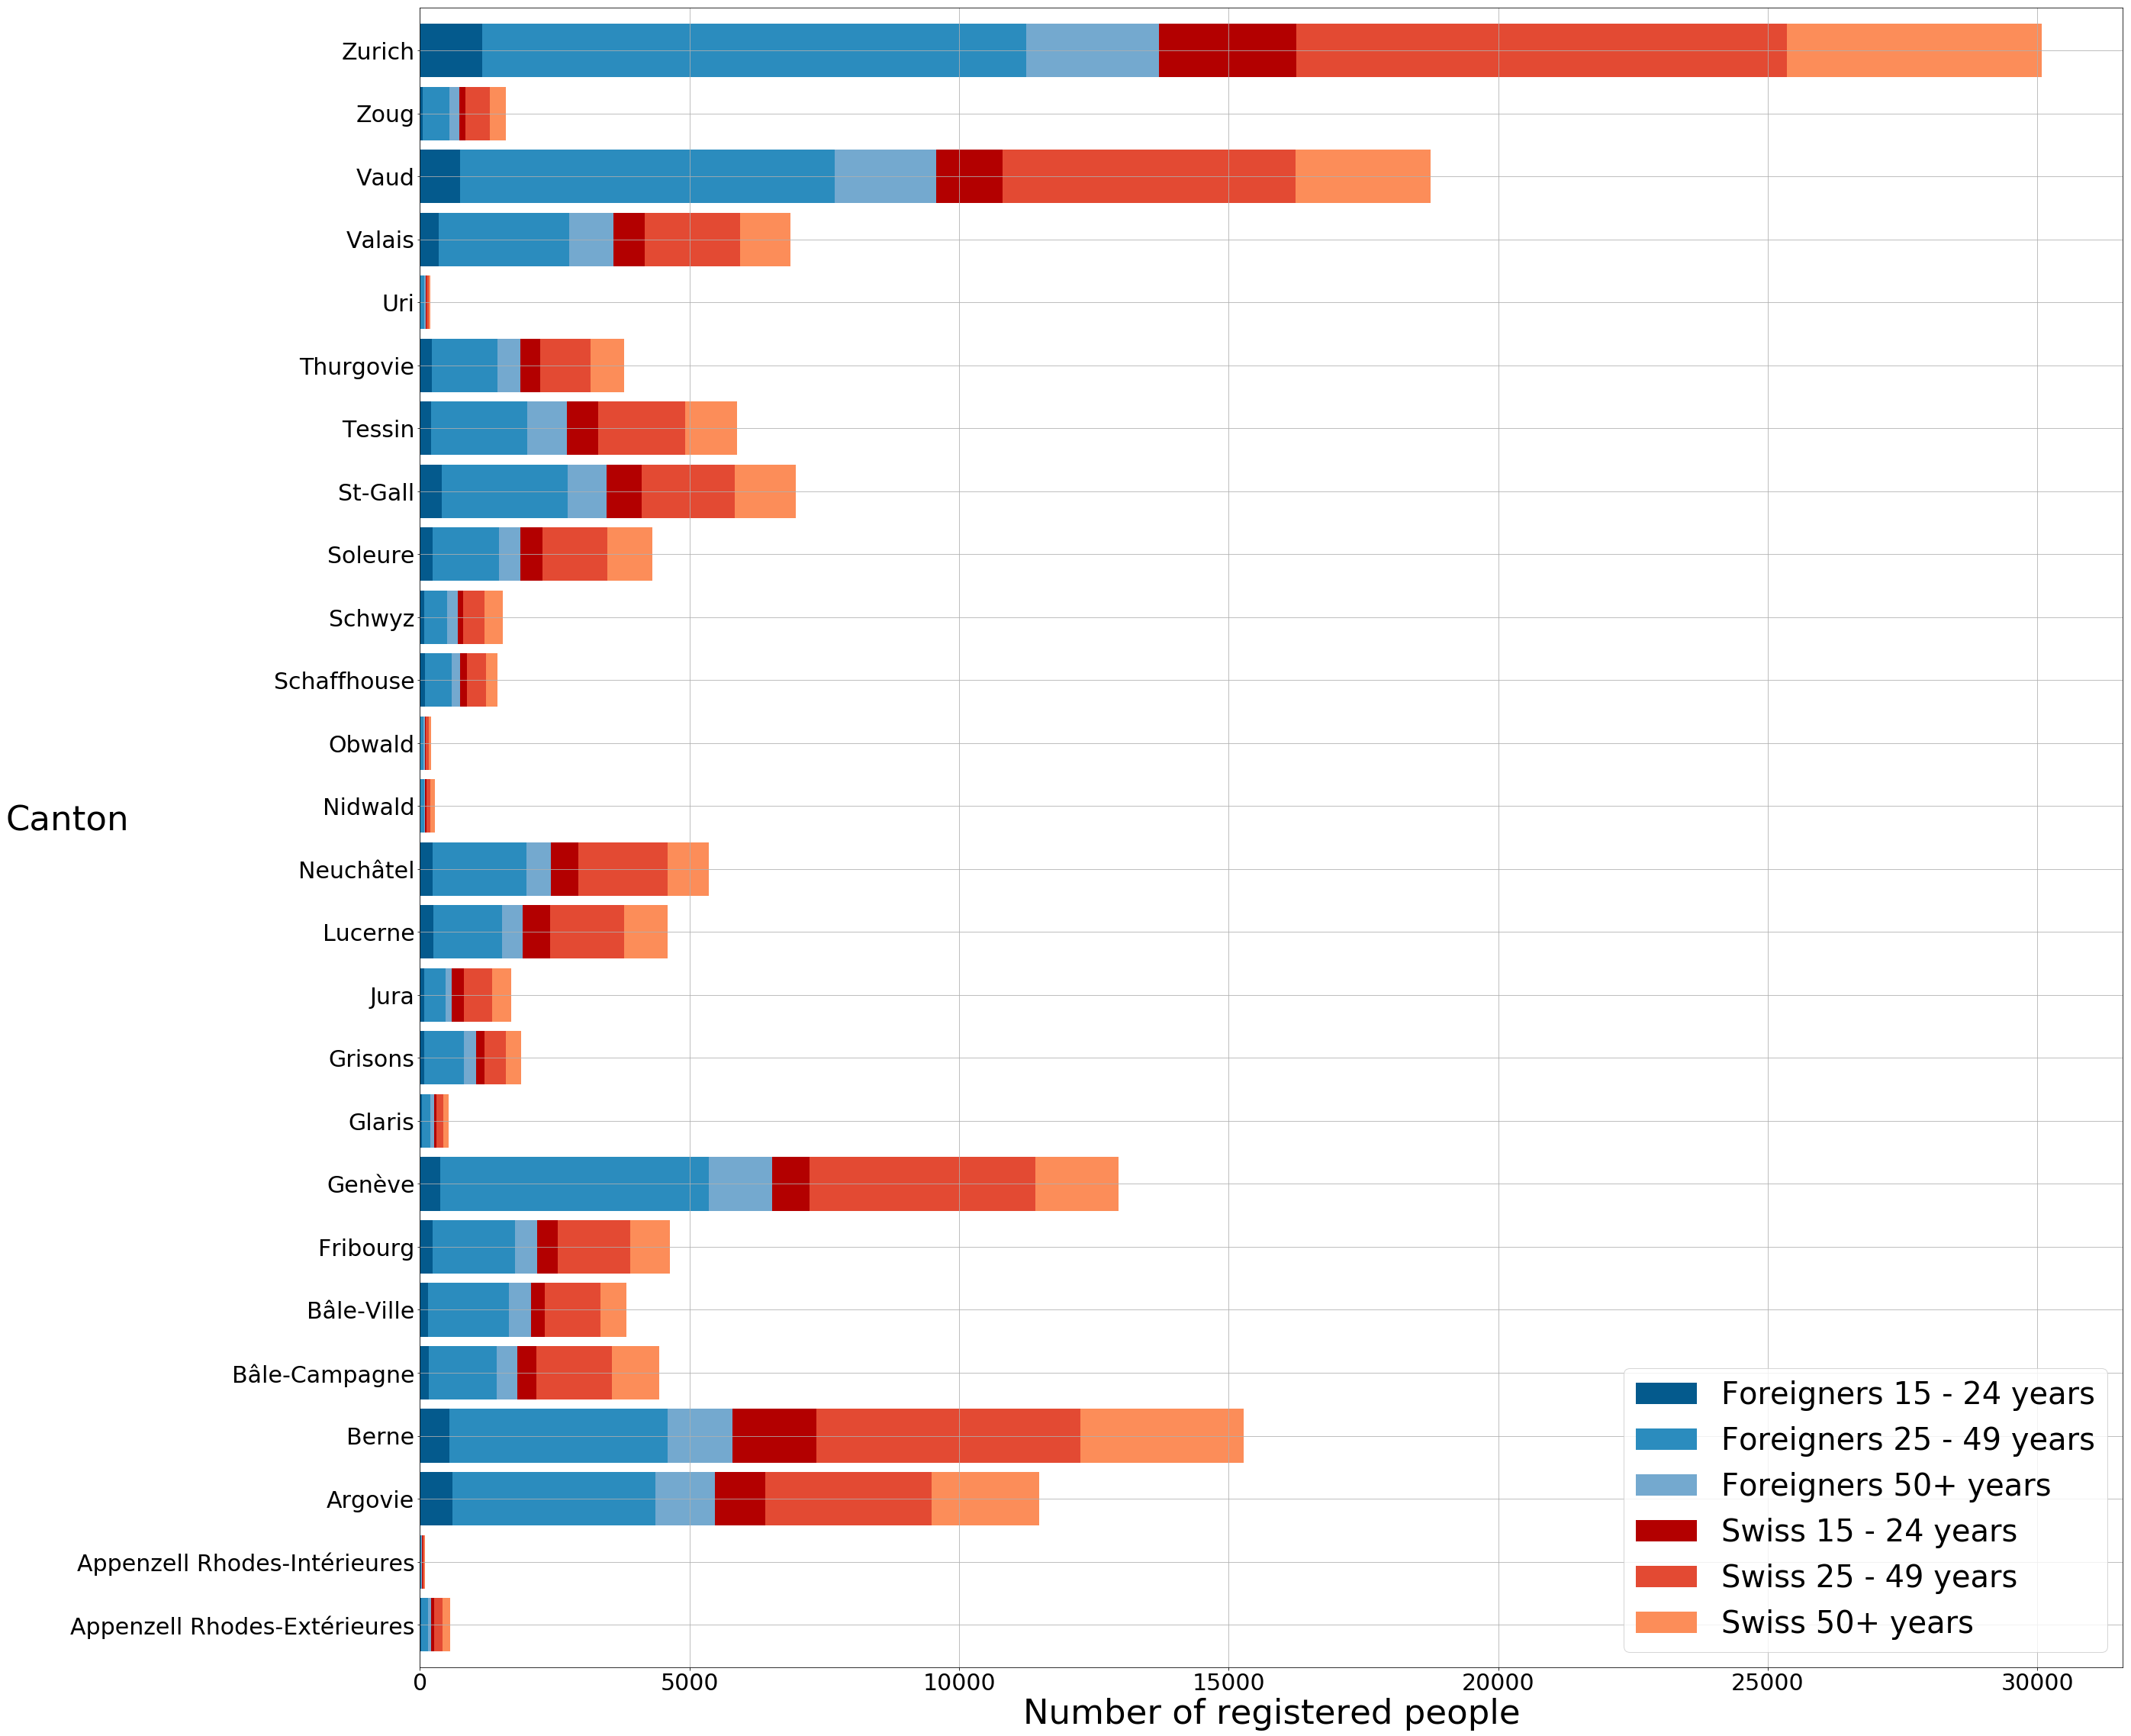

In [22]:
rcParams['figure.figsize'] = 40,40
swiss_unemployment_nationality_age_rates.plot.barh(stacked=True, grid =True,fontsize= 30,width = 0.85,
                                                  color=['#045a8d', '#2b8cbe', '#74a9cf','#b30000', '#e34a33', '#fc8d59'])
plt.xlabel('Number of registered people',fontsize = 45)
plt.ylabel('Canton', fontsize=45,rotation = 0)
plt.legend(
   fontsize=40)
plt.show()

# 4  Bonus: Röstigraben Delimitation

As we want to see how much the result is close to the Röstigraben; the geographical delimitation of the different languages in Swiss, we decided to divide the choropleth map into 4 categories. 

For simplicity, we assigned a single language to each canton. Hence the Romansh language was omitted as it's not dominating enough any canton, to be worth showing.

The four categories were obtained using 2 dimensions: the unemployment of foreigners and the unemployment of swiss. We then divided the two axis into two distinct categories ( the high and low unemployment) at the mean. Hence we will have 4 categories: 
- Purple: High unemployment for foreigners and swiss
- White: Low unemployment for foreigners and swiss
- Red: Low unemployment for foreigners and high unemployment for foreigners swiss
- Blue: High unemployment for foreigners and low unemployment for foreigners swiss

Due to the limitation of the folium API, we displayed an explicit 2D legend below the graph.

We added a color to each language: green for italian, blue for french and black for german.

**See the map** [here](https://lkieliger.github.io/adagroup/Swiss_unemployment_rostigraben.html)

We first define all the variables needed to draw the map.

In [23]:
map_ = folium.Map([46.919393, 8.334115], tiles='cartodbpositron', zoom_start=8)

# Define new variables to draw the map
unemployment_swiss_dict = swiss_unemployment_swiss_rates.set_index('Canton')['Taux de chômage (1 cav)']
unemployment_foreign_dict = swiss_unemployment_foreign_rates.set_index('Canton')['Taux de chômage (1 cav)']

# Define the mean unemployment of foreigners and swiss
foreign_mean = unemployment_foreign_dict.mean()
swiss_mean = unemployment_swiss_dict.mean()

# Define the min unemployment of foreigners and swiss
foreign_min = unemployment_foreign_dict.min()
swiss_min = unemployment_swiss_dict.min()

# Define the max unemployment of foreigners and swiss
foreign_max = unemployment_foreign_dict.max()
swiss_max = unemployment_swiss_dict.max()

# Define the colors for the different categories.
unem_swiss_unem_foreign_color = '#ae017e'
unem_swiss_em_foreign_color = '#fc4e2a'
em_swiss_unem_foreign_color = '#1d91c0'
em_swiss_em_foreign_color = '#fde0dd'

# Define the colors for the different languages
color_french = '#2c7fb8'
color_italian = '#2ca25f'
color_german = '#636363'

Then, we add two functions that wiil be able to map the different categories to different colors.

In [24]:
# This color function will map each unemployment categories to it's corresponding color
def color_function_employment(feature):
    if unemployment_swiss_dict[feature['id']] > swiss_mean:
        if unemployment_foreign_dict[feature['id']] > foreign_mean:
            return unem_swiss_unem_foreign_color
        else:
            return unem_swiss_em_foreign_color
    else:
        if unemployment_foreign_dict[feature['id']] > foreign_mean:
            return em_swiss_unem_foreign_color
        else:
            return em_swiss_em_foreign_color

# This color function will map each language to it's corresponding color
def color_function_Röstigraben(feature):
    if feature['id'] == 'TI':
            return color_italian
    elif feature['id'] == 'GE' or feature['id'] == 'VD' or \
        feature['id'] == 'FR' or feature['id'] == 'NE' or  \
        feature['id'] == 'VS' or feature['id'] == 'JU':
        return color_french
    else:
        return color_german

Finally we draw every layers and the colormaps (legends).

In [25]:
# Add unemployment map
folium.TopoJson(
    swiss_json,
    name = 'language',
    object_path ='objects.cantons',
    style_function=lambda feature: {
        'fillColor': color_function_Röstigraben(feature),
    }
).add_to(map_)

# Add nationality map
folium.TopoJson(
    swiss_json,
    name = 'Unemployment rate by language'.
    object_path ='objects.cantons',
    style_function=lambda feature: {
        'fillColor': color_function_employment(feature),
    }
).add_to(map_)

# Add legend for unemployment rate of Swiss for low unemployment rate of Foreigners
step = cm.StepColormap(
    [em_swiss_em_foreign_color, unem_swiss_em_foreign_color],
   vmin= swiss_min,vmax = swiss_max,
    index=[swiss_min, swiss_mean,swiss_max],
    caption='Unemployment rate of Swiss for low unemployment rate of Foreigners'
).add_to(map_)

# Add legend for unemployment rate of Swiss for high unemployment rate of Foreigners
step = cm.StepColormap(
    [em_swiss_unem_foreign_color, unem_swiss_unem_foreign_color],
    vmin= swiss_min,vmax = swiss_max,
    index=[swiss_min, swiss_mean,swiss_max],
    caption='Unemployment rate of Swiss for high unemployment rate of Foreigners'
).add_to(map_)

# Add legend for nationality
step = cm.StepColormap(
    [color_french, color_italian, color_german],
    vmin= 0,vmax = 3,
    index=[0, 1,2],
    caption='Language: French                         Italian                                 German'
).add_to(map_)

folium.LayerControl(collapsed=False).add_to(map_)

map_.save('Swiss_unemployment_rostigraben.html')

# display(map_)

Due to limitation of the folium API, we displayed an explicit 2D legend below the graph:

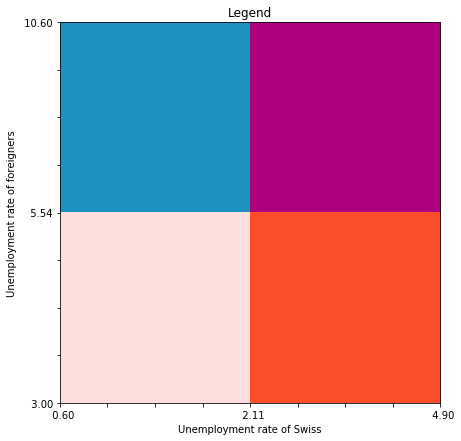

In [26]:
rcParams['figure.figsize'] = 7,7
data = [[1,2],[3,4]]
fig, ax = plt.subplots()

# create discrete colormap
cmap = colors.ListedColormap(['#1d91c0', '#ae017e','#fde0dd','#fc4e2a'])

ax.imshow(data, cmap=cmap)
ax.set_xlabel('Unemployment rate of Swiss')
ax.set_ylabel('Unemployment rate of foreigners')
ax.set_title('Legend')

fig.canvas.draw()
labels_x = [swiss_min,0,0,swiss_mean,0,0,swiss_max]
labels_x = ["{:6.2f}".format(i) for i in labels_x]
labels_x[1:3] = ['','','']
labels_x[5:7] = ['','','']

labels_y = [foreign_max,0,0,foreign_mean,0,0,foreign_min]
labels_y = ["{:6.2f}".format(i) for i in labels_y]
labels_y[1:3] = ['','','']
labels_y[5:7] = ['','','']


ax.set_xticklabels(labels_x)
ax.set_yticklabels(labels_y)

plt.show()

If we play a bit with the layers we see that there is a correlation between the french talking part of Switzerland and the high unemployment (blue language and purple unemployment category). The Tessin (italian part) can be distinguished from it's neighbors (the only red). Lastly we see that the german part is a bit more difficult to spot, as this region contains every categories.
Those results can be explained by the different economic situation of France, Italy and Germany.

It could also be noted that the linguistic region don't obey the geographical law of cantons; a canton can have two different language (Fribourg is a good example); hence trying to identify the röstigraben using cantons will not be able to give perfect results by definition.

Hence we can almost identify the röstigraben, at least for the italian and french speaking part of the country.